Проект- Анализ данных о вакцинации от COVID-19

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go




df = pd.read_csv('country_vaccinations.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86512 entries, 0 to 86511
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              86512 non-null  object 
 1   iso_code                             86512 non-null  object 
 2   date                                 86512 non-null  object 
 3   total_vaccinations                   43607 non-null  float64
 4   people_vaccinated                    41294 non-null  float64
 5   people_fully_vaccinated              38802 non-null  float64
 6   daily_vaccinations_raw               35362 non-null  float64
 7   daily_vaccinations                   86213 non-null  float64
 8   total_vaccinations_per_hundred       43607 non-null  float64
 9   people_vaccinated_per_hundred        41294 non-null  float64
 10  people_fully_vaccinated_per_hundred  38802 non-null  float64
 11  daily_vaccinations_per_milli

Как видно на изображении, в наборе данных присутствует много пропущенных значений (null). Мы обработаем их далее в этой статье.

Типы данных в таблице представлены как:

object (текстовые/строковые данные)

float (вещественные числа).


In [3]:
df.isnull().sum()

country                                    0
iso_code                                   0
date                                       0
total_vaccinations                     42905
people_vaccinated                      45218
people_fully_vaccinated                47710
daily_vaccinations_raw                 51150
daily_vaccinations                       299
total_vaccinations_per_hundred         42905
people_vaccinated_per_hundred          45218
people_fully_vaccinated_per_hundred    47710
daily_vaccinations_per_million           299
vaccines                                   0
source_name                                0
source_website                             0
dtype: int64

Эта функция выводит количество отсутствующих значений (NA) по каждому полю датасета.

Согласно данным, некоторые признаки (например, country) полностью заполнены, тогда как people_fully_vaccinated содержит 47710 пропусков, что требует дополнительной обработки.

**Предварительная обработка и очистка данных**

In [4]:
# Преобразование даты
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Сортировка
df = df.sort_values(['country', 'date'])

# Для кумулятивных показателей
cumulative_cols = [
    'total_vaccinations', 
    'people_vaccinated',
    'people_fully_vaccinated'
]

for col in cumulative_cols:
    if col in df.columns:
        # Более аккуратное заполнение только внутри групп
        df[col] = df.groupby('country')[col].transform(
            lambda x: x.ffill().bfill()
        )

# Для процентных показателей (не заполняем нулями!)
percent_cols = [
    'total_vaccinations_per_hundred',
    'people_vaccinated_per_hundred',
    'people_fully_vaccinated_per_hundred'
]

for col in percent_cols:
    if col in df.columns:
        df[col] = df.groupby('country')[col].ffill()

# Для ежедневных показателей оставляем NaN где данных нет
daily_cols = [
    'daily_vaccinations_raw',
    'daily_vaccinations', 
    'daily_vaccinations_per_million'
]

# Преобразование типов с сохранением дробной части
df[daily_cols] = df[daily_cols].apply(pd.to_numeric, errors='coerce')

Как мы уже видели, в наборе данных присутствует множество пропущенных значений (null). Прежде чем переходить к анализу, необходимо очистить данные.

Краткое описание что делает этот код:

Преобразует даты в правильный формат

Сортирует данные по странам и датам

Заполняет пропуски в накапливающихся показателях (используя предыдущие/следующие значения)

Заменяет все оставшиеся пропуски нулями

Преобразует числовые колонки в целые числа

**Обзор данных и общая статистика**

In [5]:

# Статистика по датам
print('Дата начала данных:', df['date'].min().strftime('%Y-%m-%d'))
print('Дата окончания данных:', df['date'].max().strftime('%Y-%m-%d'), '\n')

# Выводим статистику по странам и вакцинам 
print('Общее количество стран в наборе данных:', len(df['country'].unique()))
print('Общее количество уникальных вакцин в наборе данных:', len(df['vaccines'].unique()), '\n')

# Дополнительная полезная статистика 
print('Продолжительность данных:', (df['date'].max() - df['date'].min()).days, 'дней')
print('Общее количество записей о вакцинации:', len(df))

Дата начала данных: 2020-12-02
Дата окончания данных: 2022-03-29 

Общее количество стран в наборе данных: 223
Общее количество уникальных вакцин в наборе данных: 84 

Продолжительность данных: 482 дней
Общее количество записей о вакцинации: 86512


In [6]:
df.describe()

,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million
count,86512,8.651200e+04,8.651200e+04,8.651200e+04,3.536200e+04,8.621300e+04,86481.000000,85725.000000,76023.000000,86213.000000
mean,2021-09-01 17:09:45.907157504,2.589548e+07,1.461117e+07,1.223773e+07,2.705996e+05,1.313055e+05,67.139746,35.194628,31.415665,3257.049157
min,2020-12-02 00:00:00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2021-05-27 00:00:00,1.181850e+05,7.649100e+04,3.652700e+04,4.668000e+03,9.000000e+02,6.950000,5.450000,4.350000,636.000000
50%,2021-09-04 00:00:00,1.082319e+06,7.115200e+05,3.982415e+05,2.530900e+04,7.343000e+03,47.390000,30.160000,24.300000,2050.000000
75%,2021-12-12 00:00:00,8.265793e+06,4.536991e+06,3.285888e+06,1.234925e+05,4.409800e+04,118.410000,62.920000,57.520000,4682.000000
max,2022-03-29 00:00:00,3.263129e+09,1.275541e+09,1.240777e+09,2.474100e+07,2.242429e+07,345.370000,124.760000,122.370000,117497.000000
std,NaN,1.614747e+08,8.243259e+07,7.725045e+07,1.212427e+06,7.682388e+05,65.231748,29.489200,28.027575,3934.312440


Функция describe() в библиотеке Pandas используется для получения статистической сводки по каждому столбцу (признаку) в наборе данных. Эта функция особенно полезна на этапе разведочного анализа данных (EDA), так как позволяет быстро оценить распределение значений и выявить потенциальные аномалии в данных.





***Визуализация данных:***

**Распределение вакцинаций по сранам**

In [7]:
def plot_map(metric_column, title_text, color_scale):
    # Для категориальных данных (вакцины)
    if metric_column == 'vaccines':
        # Получаем уникальные вакцины (разбиваем комбинированные записи)
        unique_vaccines = set()
        for vaccine_list in df['vaccines'].str.split(', '):
            unique_vaccines.update(vaccine_list)
        
        # Создаем словарь цветов
        colors = px.colors.qualitative.Plotly
        color_map = {v: colors[i % len(colors)] for i, v in enumerate(unique_vaccines)}
        
        # Разбиваем комбинированные записи
        exploded = df.assign(vaccine=df['vaccines'].str.split(', ')).explode('vaccine')
        
        fig = px.choropleth(exploded.groupby(['country', 'vaccine']).size().reset_index(name='count'),
                           locations="country",
                           locationmode='country names',
                           color="vaccine",
                           color_discrete_map=color_map,
                           title=title_text,
                           hover_name="country",
                           hover_data=["vaccine", "count"])
    else:
        # Для числовых данных
        country_data = df.groupby('country')[metric_column].max().reset_index()
        fig = px.choropleth(country_data,
                           locations="country",
                           locationmode='country names',
                           color=metric_column,
                           color_continuous_scale=color_scale,
                           title=title_text,
                           range_color=[0, 100] if 'percent' in metric_column else None)
    
    fig.update_geos(showcoastlines=True, coastlinecolor="gray")
    fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    fig.show()

# Вызов функции для вакцин
plot_map('vaccines', 'Используемые вакцины по странам', None)

**Анализ карты вакцинации**

Данная визуализация позволяет нам сделать несколько ключевых выводов:

1. Распределение вакцин по странам:

Четко прослеживается географическая специфика использования разных типов вакцин

Некоторые страны используют комбинации нескольких вакцин, что может говорить о:

  *Стратегии диверсификации поставок

  *Локальных клинических испытаниях

  *Политических решениях в выборе поставщиков

2. Интенсивность вакцинации:

Цветовая шкала показывает уровень охвата населения

Яркие различия между регионами могут указывать на:

  *Экономические факторы
 
  *Логистические возможности

Разные сроки начала кампаний вакцинации

     Практическое применение:

Выявление стран с низким охватом для целевой помощи

Анализ эффективности разных комбинаций вакцин

Сравнение стратегий вакцинации между регионами

Прогнозирование сроков достижения коллективного иммунитета

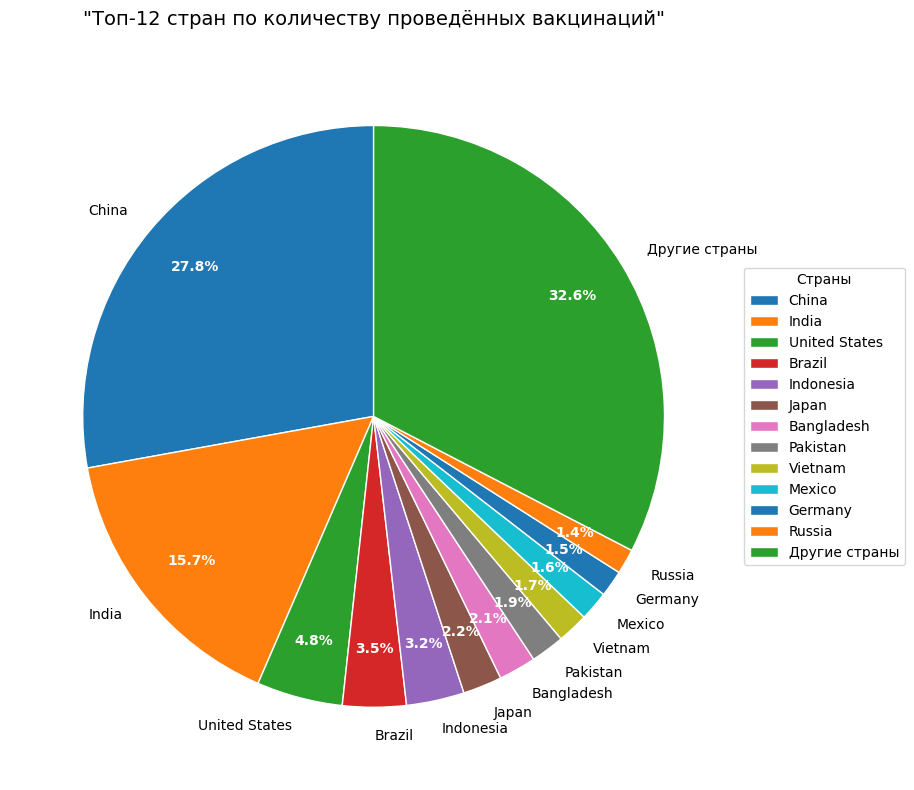

In [8]:
# 1. Подготовка данных
total_by_country = df.groupby('country')['total_vaccinations'].max().sort_values(ascending=False)
top_12 = total_by_country.head(12)
others = pd.Series({'Другие страны': total_by_country[10:].sum()})
combined = pd.concat([top_12, others])

# 2. Создание круговой диаграммы
plt.figure(figsize=(10, 8))
patches, texts, autotexts = plt.pie(combined,
                                   labels=combined.index,
                                   autopct='%1.1f%%',
                                   startangle=90,
                                   pctdistance=0.8,
                                   textprops={'fontsize': 10},
                                   wedgeprops={'linewidth': 1, 'edgecolor': 'white'})

# 3. Настройка отображения
plt.setp(texts, size=10)
plt.setp(autotexts, size=10, color='white', weight='bold')
plt.title('"Топ-12 стран по количеству проведённых вакцинаций"', fontsize=14, pad=20)

# 4. Добавление легенды
plt.legend(patches,
           combined.index,
           title="Страны",
           loc="center left",
           bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

**Анализ распределения вакцинаций по странам (Топ-12)**

Данная круговая диаграмма наглядно демонстрирует распределение общего количества вакцинаций между странами, выделяя 12 лидеров по объёмам вакцинации и объединяя остальные страны в группу "Другие".


**Ключевые выводы:**

Доминирование нескольких стран - диаграмма показывает значительное неравномерное распределение, где небольшая группа стран обеспечивает основной объём вакцинаций

Сравнение масштабов - позволяет визуально сравнить вклад разных стран в общий процесс вакцинации

Доля "других стран" - показывает, насколько велик вклад стран, не вошедших в топ-12

     Практическое применение:

Выявление лидеров для изучения их опыта

Определение стран, нуждающихся в поддержке

Анализ корреляции с демографическими показателями

Оценка эффективности глобальных программ вакцинации

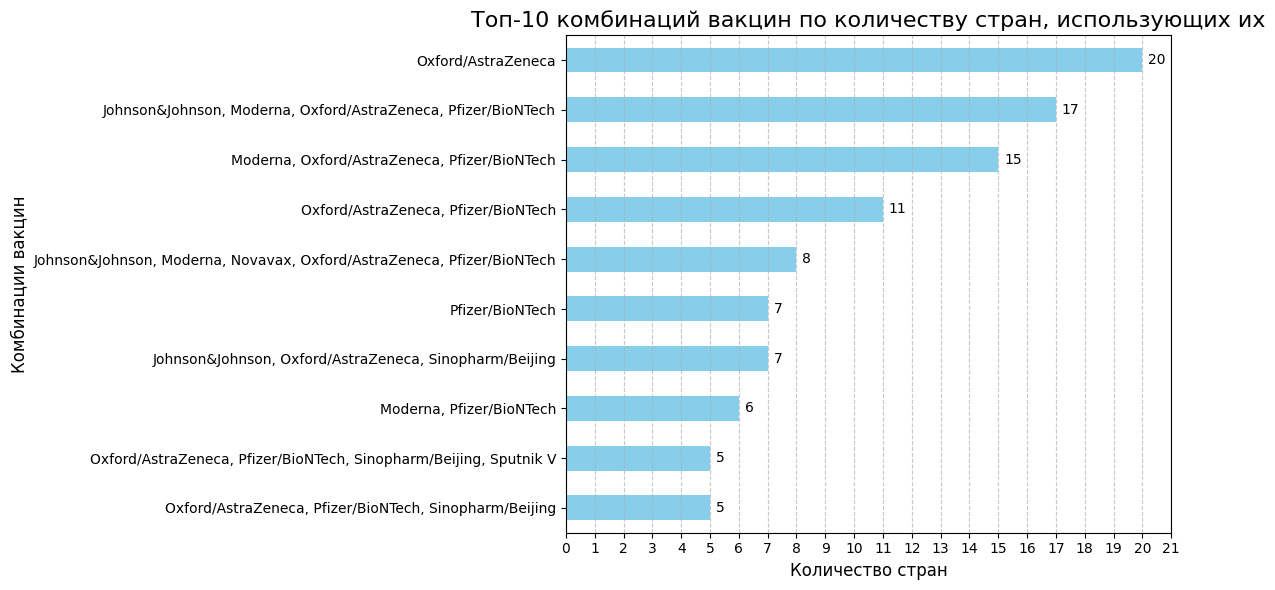

In [9]:
# Группируем по комбинациям вакцин и считаем УНИКАЛЬНЫЕ страны
vaccine_stats = df.groupby('vaccines')['country'].nunique().sort_values(ascending=False).head(10)

# Визуализация
plt.figure(figsize=(12, 6)) 
vaccine_stats.plot(kind='barh', color='skyblue')
plt.title('Топ-10 комбинаций вакцин по количеству стран, использующих их', fontsize=16) 
plt.xlabel('Количество стран', fontsize=12)
plt.ylabel('Комбинации вакцин', fontsize=12)

# Устанавливаем целочисленные значения на оси X
max_count = int(vaccine_stats.max()) + 2 # Максимальное значение + небольшой запас
plt.xticks(np.arange(0, max_count, step=1)) # Шаг = 1

plt.gca().invert_yaxis() # Первое место сверху

# Добавляем подписи значений на столбцы для лучшей читаемости
for index, value in enumerate(vaccine_stats):
    plt.text(value + 0.2, index, str(value), va='center') # Размещение текста

plt.grid(axis='x', linestyle='--', alpha=0.7) # Добавляем сетку по оси X
plt.tight_layout() # Автоматически корректирует параметры подграфиков для плотного размещения
plt.show()

**Инсайты об использовании комбинаций вакцин:**

* **Доминирующие комбинации:** График наглядно показывает, что большинство стран используют одну или несколько широко распространенных вакцин. Можно отметить, что наиболее распространенными являются комбинации с **Oxford/AstraZeneca**, используемой в **20** странах.
* **Разнообразие стратегий:** Некоторые страны предпочитали использовать ограниченный набор вакцин, в то время как другие (особенно те, которые используют 4+ комбинации), вероятно, придерживались стратегии диверсификации поставок для обеспечения максимального охвата.
* **Логистические вызовы:** Широкое разнообразие вакцин может создавать сложности для логистики и хранения, а также для информирования населения.

**Метрики прогресса вакцинации в России:**

Метрики прогресса вакцинации в России:
Первая дата вакцинации: 2020-12-15
Последняя дата вакцинации: 2022-03-29
Максимальный процент вакцинированных: 54.8%
Максимальный процент полностью вакцинированных: 49.92%
Максимальное число дневных вакцинаций: 1,020,075.0


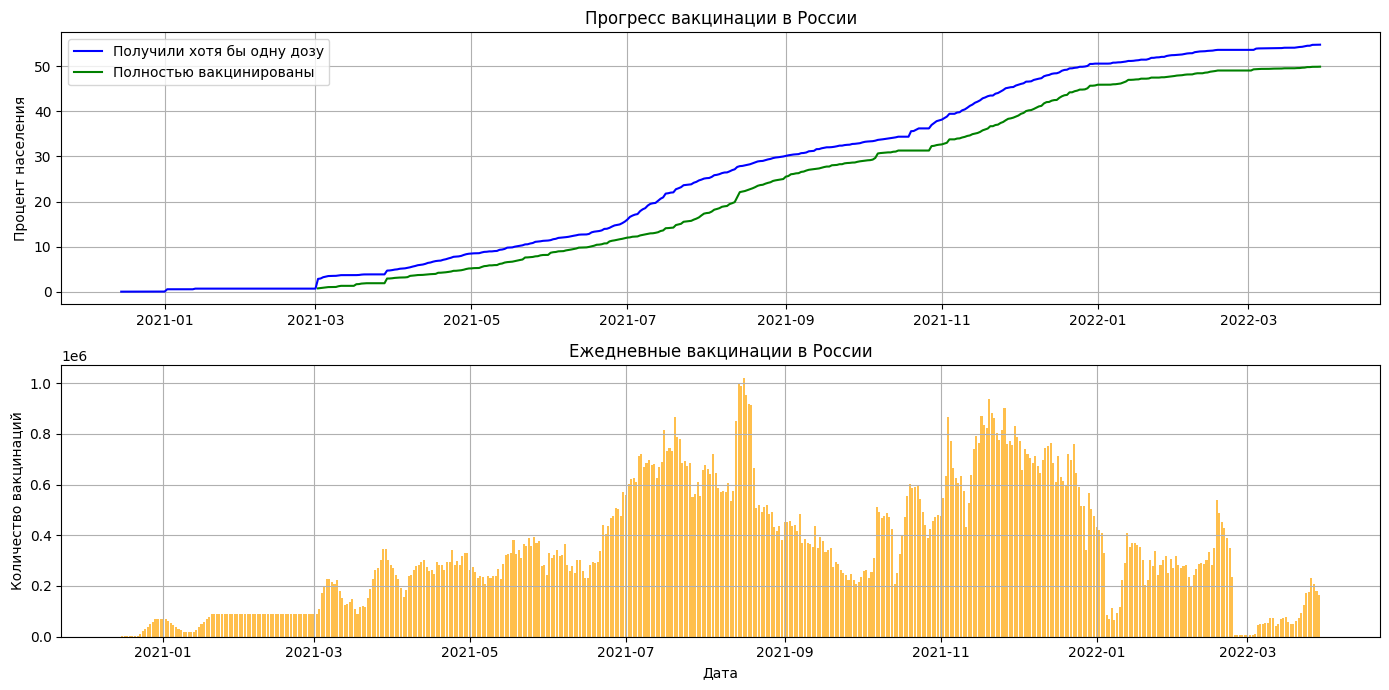


Последние доступные данные:
Дата: 2022-03-29
Процент населения с хотя бы одной дозой: 54.80%
Процент полностью вакцинированных: 49.92%
Общее количество вакцинаций: 163,601,171.0
Дневных вакцинаций: 165,417.0


In [10]:
# Фильтрация данных по России
russia_data = df[df['country'] == 'Russia'].copy()

# Преобразование даты в datetime для правильной сортировки
russia_data['date'] = pd.to_datetime(russia_data['date'])
russia_data.sort_values('date', inplace=True)

# Расчет метрик прогресса
print("Метрики прогресса вакцинации в России:")
print(f"Первая дата вакцинации: {russia_data['date'].min().strftime('%Y-%m-%d')}")
print(f"Последняя дата вакцинации: {russia_data['date'].max().strftime('%Y-%m-%d')}")
print(f"Максимальный процент вакцинированных: {russia_data['people_vaccinated_per_hundred'].max()}%")
print(f"Максимальный процент полностью вакцинированных: {russia_data['people_fully_vaccinated_per_hundred'].max()}%")
print(f"Максимальное число дневных вакцинаций: {russia_data['daily_vaccinations'].max():,}")

# Визуализация прогресса
plt.figure(figsize=(14, 7))

# График процента вакцинированных
plt.subplot(2, 1, 1)
plt.plot(russia_data['date'], russia_data['people_vaccinated_per_hundred'], 
         label='Получили хотя бы одну дозу', color='blue')
plt.plot(russia_data['date'], russia_data['people_fully_vaccinated_per_hundred'], 
         label='Полностью вакцинированы', color='green')
plt.title('Прогресс вакцинации в России')
plt.ylabel('Процент населения')
plt.legend()
plt.grid()

# График ежедневных вакцинаций
plt.subplot(2, 1, 2)
plt.bar(russia_data['date'], russia_data['daily_vaccinations'], 
        color='orange', alpha=0.7)
plt.title('Ежедневные вакцинации в России')
plt.ylabel('Количество вакцинаций')
plt.xlabel('Дата')
plt.grid()

plt.tight_layout()
plt.show()

# Расчет кумулятивного процента вакцинированных
total_population = 144_100_000  # Примерная численность населения России
russia_data['total_vaccinated_percent'] = russia_data['people_vaccinated'] / total_population * 100
russia_data['fully_vaccinated_percent'] = russia_data['people_fully_vaccinated'] / total_population * 100

# Вывод последних доступных данных
latest_data = russia_data.iloc[-1]
print("\nПоследние доступные данные:")
print(f"Дата: {latest_data['date'].strftime('%Y-%m-%d')}")
print(f"Процент населения с хотя бы одной дозой: {latest_data['people_vaccinated_per_hundred']:.2f}%")
print(f"Процент полностью вакцинированных: {latest_data['people_fully_vaccinated_per_hundred']:.2f}%")
print(f"Общее количество вакцинаций: {latest_data['total_vaccinations']:,}")
print(f"Дневных вакцинаций: {latest_data['daily_vaccinations']:,}")

**Анализ вакцинации в России (12.2020 - 03.2022)**
Ключевые показатели:

Период кампании: 15.12.2020 - 29.03.2022 (15 месяцев)

**Охват населения:**

54.8% - получили ≥1 дозу

49.92% - полностью вакцинированы

Пиковая активность: 1,020,075 доз/день

Итоговые показатели (на 29.03.2022):

Всего введено доз: 163.6 млн

Последние сутки: 165,417 доз

**Тенденции:**

Максимальный суточный показатель превышал 1 млн доз

Разрыв между первой и второй дозой составил ~5%

Завершающий этап (03.2022) показывает снижение темпов до ~165 тыс. доз/день

**Сравнение с мировыми показателями:**

Охват первой дозой (54.8%) ниже среднего по ЕС (~75% на 2022 г.)

Полная вакцинация (49.92%) соответствует уровню развивающихся стран



